<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       2938 non-null   object 
 1   Year                          2938 non-null   int64  
 2   Status                        2938 non-null   object 
 3   Lifeexpectancy                2928 non-null   float64
 4   AdultMortality                2928 non-null   float64
 5   infantdeaths                  2938 non-null   int64  
 6   Alcohol                       2744 non-null   float64
 7   percentageexpenditure         2938 non-null   float64
 8   HepatitisB                    2385 non-null   float64
 9   Measles                       2938 non-null   int64  
 10  BMI                           2904 non-null   float64
 11  under-fivedeaths              2938 non-null   int64  
 12  Polio                         2919 non-null   float64
 13  Tot

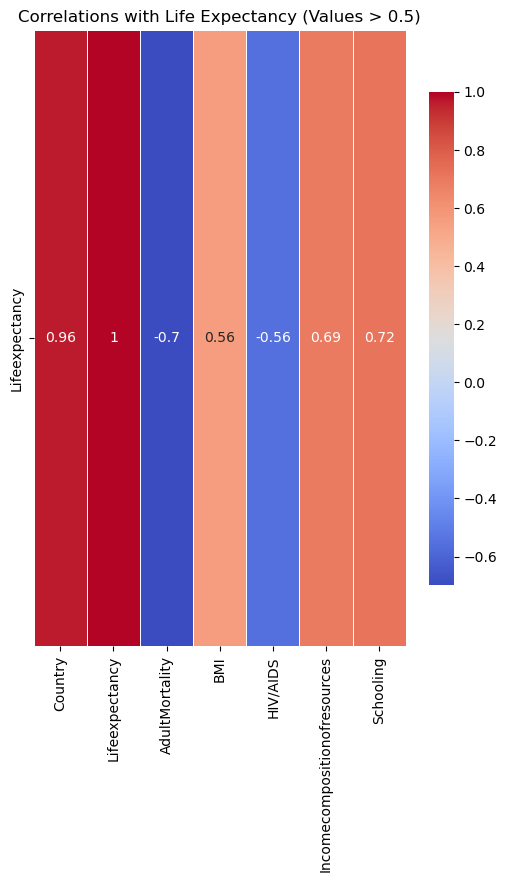

Linear Regression MSE: 4.93778165493146
Linear Regression R2: 0.9430049532800769
Random Forest MSE: 2.009571711150129
Random Forest R2: 0.9768042328381109
Linear Regression Performance:
Precision: 0.9615917450914824
Recall: 0.9555848932057145
F1 Score: 0.9581593927893739
Accuracy: 0.9591836734693877
Random Forest Performance:
Precision: 0.9831349206349206
Recall: 0.982200952425857
F1 Score: 0.9826558905079346
Accuracy: 0.9829931972789115


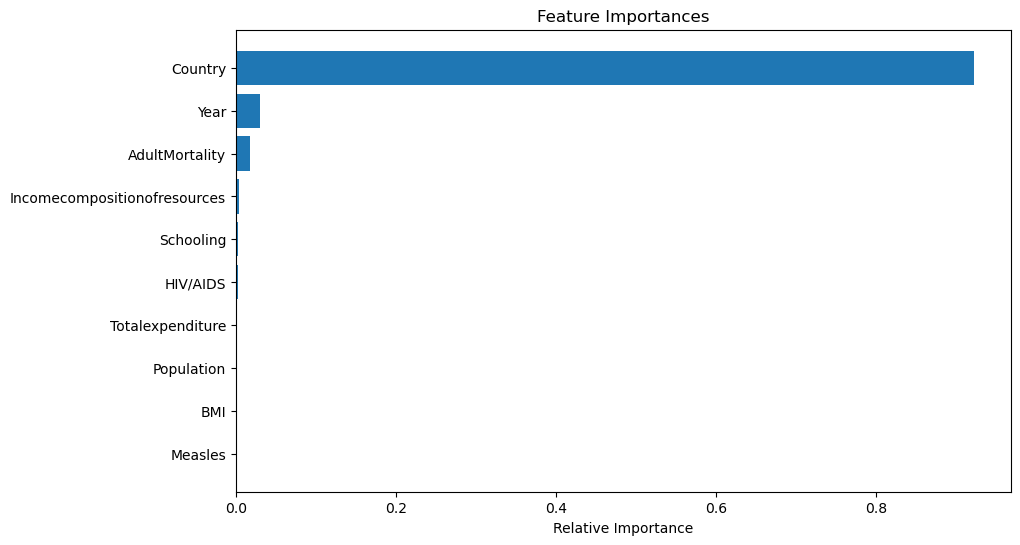

Random Forest (Important Features) MSE: 2.0613346859837383
Random Forest (Important Features) R2: 0.9762067513423349
The chosen model for deployment is: Random Forest (Important Features)
Predicted Life Expectancy: 64.51699999999998


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, accuracy_score
from category_encoders import TargetEncoder
import joblib

# Load the dataset
df = pd.read_csv('led.csv')

# Display basic information about the dataset
print(df.info())
print(df.describe())
print(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

# Handling missing values
# Fill missing numeric values with the mean
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Fill missing categorical values with the mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Encode categorical features using Target Encoder
categorical_features = ['Country', 'Status']
encoder = TargetEncoder(cols=categorical_features)
df[categorical_features] = encoder.fit_transform(df[categorical_features], df['Lifeexpectancy'])

# Assuming 'df' is your DataFrame
correlation_matrix = df.corr()

# Extract correlations relative to 'Lifeexpectancy'
correlations = correlation_matrix[['Lifeexpectancy']]

# Filter correlations to keep only values greater than 0.5
filtered_correlations = correlations[correlations['Lifeexpectancy'].abs() > 0.5]

# Create a heatmap
plt.figure(figsize=(6, 8))
sns.heatmap(filtered_correlations.T, annot=True, cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlations with Life Expectancy (Values > 0.5)')
plt.show()

# Define the important features based on the correlation matrix
important_features = filtered_correlations.index.tolist()
important_features.remove('Lifeexpectancy')  # Remove the target column itself

# Define the feature columns and target column
X = df.drop(['Lifeexpectancy'], axis=1)
y = df['Lifeexpectancy']

# Define X_important for Multiple Linear Regression using important features
X_important = df[important_features]

# Split the data into training and testing sets for both models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_important_train, X_important_test, y_important_train, y_important_test = train_test_split(X_important, y, test_size=0.2, random_state=42)

# Multiple Linear Regression using important features
lr_model = LinearRegression()
lr_model.fit(X_important_train, y_important_train)
y_pred_lr = lr_model.predict(X_important_test)

# Random Forest Regression using all features
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate models
print("Linear Regression MSE:", mean_squared_error(y_important_test, y_pred_lr))
print("Linear Regression R2:", r2_score(y_important_test, y_pred_lr))
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))
print("Random Forest R2:", r2_score(y_test, y_pred_rf))

# Convert regression output to binary for example purposes
y_pred_lr_binary = [1 if pred > y.mean() else 0 for pred in y_pred_lr]
y_pred_rf_binary = [1 if pred > y.mean() else 0 for pred in y_pred_rf]
y_test_binary = [1 if actual > y.mean() else 0 for actual in y_test]

# Define a function to calculate performance metrics
def evaluate_model(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')

print("Linear Regression Performance:")
evaluate_model(y_test_binary, y_pred_lr_binary)

print("Random Forest Performance:")
evaluate_model(y_test_binary, y_pred_rf_binary)

# Feature importance for Random Forest
feature_importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)[-10:]  # Top 10 features

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Select top features based on Random Forest feature importances
important_rf_features = [features[i] for i in indices]

# Train Random Forest again with top important features
X_rf_important = df[important_rf_features]
X_rf_important_train, X_rf_important_test, y_rf_important_train, y_rf_important_test = train_test_split(X_rf_important, y, test_size=0.2, random_state=42)

rf_model_important = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_important.fit(X_rf_important_train, y_rf_important_train)
y_pred_rf_important = rf_model_important.predict(X_rf_important_test)

# Evaluate the new Random Forest model
print("Random Forest (Important Features) MSE:", mean_squared_error(y_rf_important_test, y_pred_rf_important))
print("Random Forest (Important Features) R2:", r2_score(y_rf_important_test, y_pred_rf_important))

# Save the models and encoder
joblib.dump(lr_model, 'linear_regression_model.pkl')
joblib.dump(rf_model_important, 'random_forest_model.pkl')
joblib.dump(encoder, 'target_encoder.pkl')

# Function to predict life expectancy based on input data
def predict_life_expectancy(model, input_data, important_features=None):
    if important_features:
        input_data = input_data[important_features]
    return model.predict(input_data)

# Example usage
example_data = {
    'Country': ['Afghanistan'],
    'Year': [2015],  # Example year value
    'Status': ['Developed'],
    'GDP': [40000],  # Example GDP value
    'Schooling': [15],  # Example schooling years
    'Incomecompositionofresources': [0.8]  # Example value
}

# Fill in missing columns with default values
for col in X.columns:
    if col not in example_data:
        example_data[col] = [df[col].mode()[0]] if df[col].dtype == 'object' else [df[col].mean()]

input_data = pd.DataFrame(example_data)
input_data[categorical_features] = encoder.transform(input_data[categorical_features])

# Predict using the chosen model
if r2_score(y_test, y_pred_rf) > r2_score(y_important_test, y_pred_lr):
    prediction = predict_life_expectancy(rf_model_important, input_data, important_rf_features)
    chosen_model = "Random Forest (Important Features)"
else:
    prediction = predict_life_expectancy(lr_model, input_data, important_features)
    chosen_model = "Linear Regression"

print(f"The chosen model for deployment is: {chosen_model}")
print(f"Predicted Life Expectancy: {prediction[0]}")
